<a href="https://colab.research.google.com/github/ahoiching/Chuankai_report/blob/master/Growth_curve_analysis_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.stats import linregress
from scipy.optimize import curve_fit

def sigmoid(x, a, b, c, d):
  return a / (1. + np.exp(-c * (x - d))) + b

In [2]:
from matplotlib import pyplot as plt
from matplotlib import cm

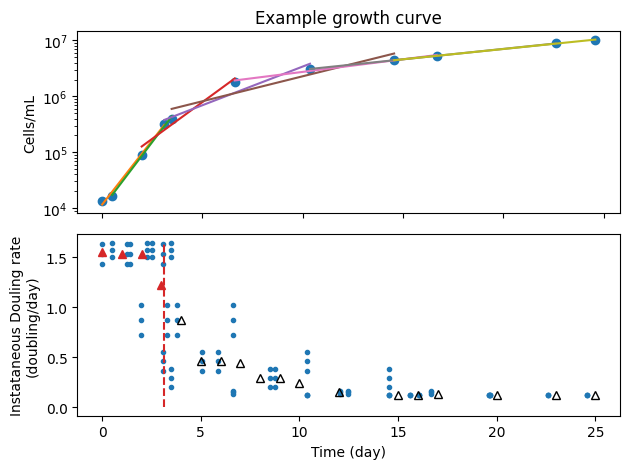

In [3]:
fig, axs = plt.subplots(nrows=2)

time = np.array([0.00000000e+00, 5.00000000e-01, 1.97222222e+00, 3.09722222e+00,
        3.46527778e+00, 6.61111111e+00, 1.03604167e+01, 1.45555556e+01,
        1.66805556e+01, 2.26145833e+01, 2.45868056e+01])
cell_density = np.array([1.35714286e+04, 1.66533333e+04, 8.94666667e+04, 3.25052632e+05,
        3.90619048e+05, 1.82660000e+06, 3.09440000e+06, 4.44080000e+06,
        5.29840000e+06, 8.86240000e+06, 1.03194000e+07])

axs[0].plot(time, cell_density, 'o')
log2cd = np.log2(cell_density)
sw = 4

idr_list = []
time_list = []

cd_candidate_list = np.array([np.max(log2cd)])

for i in range(sw, len(log2cd)+1):
  time_array = time[i-sw:i]
  if np.max(time_array)>np.min(time_array):
    LR = linregress(time_array,log2cd[i-sw:i])
    axs[0].plot(time_array, 2**(LR.slope*time_array+LR.intercept), '-')
    for idr in [LR.slope, LR.slope+LR.stderr, LR.slope-LR.stderr]:
      idr_list.append([idr, idr, idr, idr])
      time_list.append([np.max(time_array), np.median(time_array), np.mean(time_array), np.min(time_array)])

    if LR.pvalue>0.5:
      cd_candidate_list = np.r_[cd_candidate_list, [np.mean(log2cd[i-sw:i]),
                                np.median(log2cd[i-sw:i])]]

axs[0].set_yscale('log', base=10)

time_list = np.array(time_list).flatten()
idr_list = np.array(idr_list).flatten()
axs[1].plot(time_list, idr_list, '.')

unique_time = np.unique(np.round(time_list,0))
idr_median = []
for ut in unique_time:
  idr_group = idr_list[abs(time_list-ut)<=1]
  median_idr = np.median(idr_group)
  idr_median.append(median_idr)

idr_median = np.array(idr_median)

if np.mean(idr_median)<0:
  axs[1].plot(unique_time[unique_time<4],
              idr_median[unique_time<4],
              'C3^')
  axs[1].plot(unique_time[unique_time>4],
              idr_median[unique_time>4],
              'k^', mfc = 'none')
else:
  time_min = np.min(time_list[idr_list>=0.8*np.max(idr_list)])
  sel_bool = (time_list>=time_min)
  unique_time_sel = unique_time[unique_time>=time_min]
  idr_median_sel = idr_median[unique_time>=time_min]
  try:
    (a_, b_, c_, d_), _ = curve_fit(sigmoid, time_list[sel_bool], idr_list[sel_bool], method = 'trf')
    if d_>time_min+2:
      axs[1].plot(unique_time_sel[unique_time_sel<=d_],
                  idr_median_sel[unique_time_sel<=d_],
                  'C3^')
      axs[1].plot(unique_time_sel[unique_time_sel>d_],
                  idr_median_sel[unique_time_sel>d_],
                  'k^', mfc = 'none')
      axs[1].plot(unique_time[unique_time<time_min],
                  idr_median[unique_time<time_min],
                  'k^', mfc = 'none')
    else:
      axs[1].plot(unique_time_sel[unique_time_sel<(time_min+2)],
                  idr_median_sel[unique_time_sel<(time_min+2)],
                  'C3^')
      axs[1].plot(unique_time_sel[unique_time_sel>(time_min+2)],
                  idr_median_sel[unique_time_sel>(time_min+2)],
                  'k^', mfc = 'none')
      axs[1].plot(unique_time[unique_time<time_min],
                  idr_median[unique_time<time_min],
                  'k^', mfc = 'none')

    axs[1].plot([d_,d_],[0, max(idr_list)],'C3--')
  except RuntimeError:
    axs[1].plot(unique_time_sel,
                idr_median_sel,
                'C3^')
    axs[1].plot(unique_time[unique_time<time_min],
                idr_median[unique_time<time_min],
                'k^', mfc = 'none')
axs[0].set_xticklabels([])
axs[0].set_ylabel('Cells/mL')
axs[1].set_xlabel('Time (day)')
axs[1].set_ylabel('Instataneous Douling rate\n(doubling/day)')

axs[0].set_title('Example growth curve')
fig.tight_layout()
fig.show()